## https://github.com/tiagomartins-threesigma/SINFO2023FRI4STARKs

In [1]:
%run Base.ipynb

prime = 12289


# FRI Commit Phase

### Define and Evaluate the Polynomial
At this point, let us define the polynomial $p_0$ through its coefficients, for the proper low-degree test.
The code below performs the sequence of operations:
1. it defines $c_0$ as an array of field elements,
2. computes the evaluation of $p_0$ by computing the $\texttt{FFT}$ of the array of coefficients.

In [25]:
c0 = Fp([1,2,3,4,73]+[0 for x in range(BUF*d0-5)]) #)np.eye(1, BUF*d0, 54, dtype=int).ravel())
p0 = np.fft.fft(c0)

print('c0 =',c0)
print('p0 =',p0)
len(c0)

c0 = [ 1  2  3  4 73  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
p0 = [   83  1917  1537    14  2907  7487   267  5247  4574  8762 11877  4665
    93  9210  9650   404  9402  9830  3966  6148  5093 10118  2927  1082
  1900  9665   104 12121  3730 11227  1887  3775    71 10070 10574  2325
  4436 10272  9379  4504  4156  9007  3271 11745 11475  7298  8784  2366
  3029  5571  7693  1895  1610  5386  3094  1561  1371  6631 10142 10251
  7531   455   887  5647]


64

### Sequence of Degree Respecting Projections
In the commit phase, the prover forms a sequence of polynomials that depend on the random challenges provided by the verifier and commits to the evaluation of each new polynomial at the moment of creation of the corresponding FRI layer. The last layer is an exception since the prover must provide the list of polynomial coefficients. The committing procedure is the prover-verifier interaction:

1. Starting with the original polynomial $p_0$, both the prover and the verifier must compute its degree bound $d_0$.
2. In sequence, for each FRI layer $i\ge 0$ such that $d_i>1$:
    1. the verifier provides a random challenges $z_{i,0}$ and $z_{i,1}$,
    2. the prover commits on the evaluation of $p_{i+1}$, 
    where supposedly $c_{i+1} = c_{i, \text{even}} z_{i, \text{even}} + c_{i, \text{odd}} z_{i, \text{odd}}$
    3. the degree bound is reduced as $d_{i+1}=d_i/2$.
3. The last step requires the prover to commit the $d_{\mathrm{LL}}$ polynomial coefficients of $p_{\mathrm{LL}}$. Where $\mathrm{LL}$ denotes the last layer state which is when the protocol first reaches 
$d_i\le 1$.


Layer 0
c = [ 1  2  3  4 73  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
p = [   83  1917  1537    14  2907  7487   267  5247  4574  8762 11877  4665
    93  9210  9650   404  9402  9830  3966  6148  5093 10118  2927  1082
  1900  9665   104 12121  3730 11227  1887  3775    71 10070 10574  2325
  4436 10272  9379  4504  4156  9007  3271 11745 11475  7298  8784  2366
  3029  5571  7693  1895  1610  5386  3094  1561  1371  6631 10142 10251
  7531   455   887  5647]
z = [7163 6262]

Layer 1
c = [7398 9670 6761    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]
p = [11540  1518  3074  8398 11459  6720  7757  4094 10460  3714  4522  2535
  2495  1845  3998  9492  4489 10565  3748   980  8172  1763 10933  9908
  3103  1506  5959  5390  7466  6975  6904  6098]
z =

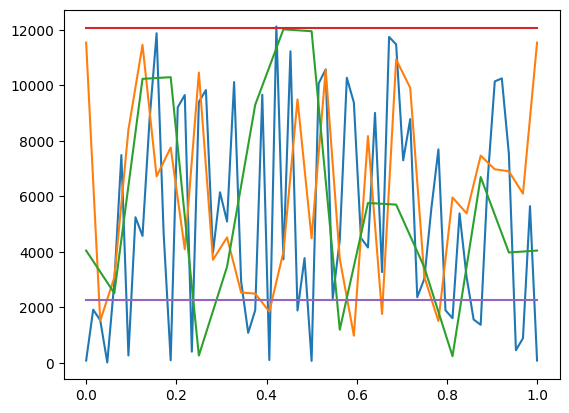

In [26]:
d = d0
c = c0
p = [p0]
z = []

while d>1:
    print_stuff(f'Layer {len(p)-1}', c,p[-1])
    
    z.append(Fp(rand(prime-1, size=2)))
    print('z =', z[-1])
    c = z[-1][0]*c[::2] + z[-1][1]*c[1::2]
    p.append(np.fft.fft(c))
    d = d//2        
print_stuff(f'Layer {len(p)-1} -> Last Layer', c, p[-1])

### Commiting to the proof

Prover commits to the evaluation of $p_i$ for all $i \in \{0, \dotsc, \mathrm{LL}\}$.

In reality, commitments are implemented by building Merkle trees over the series of field elements and sending the Merkle roots to the verifier. 

But here, we will just "save" the lists $\texttt{p}$ and $\texttt{z}$ in an external file through Pickle object serialization.

In [27]:
import pickle
file = open('FRI_Commitment_File.out', 'wb')
pickle.dump({'p':p, 'z':z} , file)
file.close()

### Testing layer by layer

The following code defines a function $\texttt{test_layers}$ that takes in the number of the layer $\texttt{i}$ and the position along said layer $\texttt{sample}$.  

It performs the sequence of operations:
1. Compute the $x$ corresponding to the layer position $\texttt{sample}$
2. Define half of the length of the layer which is useful to locate $-x$ at position $\texttt{sample-halflength}$
3. Compute $g(x^2) = (p_i(x) + p_i(-x))/2$
4. Compute $h(x^2) = (p_i(x) - p_i(-x))/(2x)$
5. Print $x, p_i(x), p_i(-x)$
6. Compute $p_{i+1}(x^2)$ from $g(x^2)$ and $h(x^2)$ and print the result
7. Print the stored result of $p_{i+1}(x^2)$ where $x^2$ is located at position $\texttt{sample%halflength}$
8. Print the value of $x^2$


In [12]:
def test_layers(i, sample):
    x = Fp.primitive_element**(2**i*sample*(prime-1)//(BUF*d0))
    halflength = len(p[i])//2
    g = (p[i][sample]+p[i][sample-halflength])/Fp(2)
    h = (p[i][sample]-p[i][sample-halflength])/(Fp(2)*x)
    
    print('x =', x)
    print(f'p_{i}(x) =', p[i][sample])
    print(f'p_{i}(-x) =', p[i][sample-halflength])
    print(f'p_{i+1}(x^2) =', z[i][0]*g + z[i][1]*h)
    print(f'p_{i+1}(x^2) =', p[i+1][sample%halflength])
    print('x**2 =', x**2)

In [17]:
test_layers(0, 32)

x = 12288
p_0(x) = 1
p_0(-x) = 1
p_1(x^2) = 6933
p_1(x^2) = 6933
x**2 = 1


In [18]:
test_layers(1, 0)

x = 1
p_1(x) = 6933
p_1(-x) = 5356
p_2(x^2) = 10213
p_2(x^2) = 10213
x**2 = 1


In [19]:
test_layers(2, 0)

x = 1
p_2(x) = 10213
p_2(-x) = 10213
p_3(x^2) = 2317
p_3(x^2) = 2317
x**2 = 1


In [20]:
test_layers(3, 0)

x = 1
p_3(x) = 2317
p_3(-x) = 2317
p_4(x^2) = 6450
p_4(x^2) = 6450
x**2 = 1
